In [1]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [2]:
class PneumoniaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_files = []
        self.img_labels = []
        
        for label in ["NORMAL", "PNEUMONIA"]:
            img_dir = os.path.join(root_dir, label)
            for img_file in os.listdir(img_dir):
                self.img_files.append(os.path.join(img_dir, img_file))
                if label == "NORMAL":
                    self.img_labels.append("normal")
                else:
                    if "bacteria" in img_file:
                        self.img_labels.append("bacterie")
                    elif "virus" in img_file:
                        self.img_labels.append("virus")

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        label_map = {'normal': 0, 'bacterie': 1, 'virus': 2}
        label = label_map[label]
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = PneumoniaDataset(root_dir='../data', transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [3]:
# Load pre-existing model (ResNet18) and modify for 3 classes
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # Assuming we have 3 classes

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

E:\anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                print(f"Batch {i+1}/{len(dataloaders[phase])} completed")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    return model

# Dataloaders for training and validation
dataloaders = {'train': train_loader, 'val': val_loader}

# Train the model
print("Starting training...")
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=10)
print("Training completed.")


Starting training...
Epoch 0/9
----------
Batch 1/14 completed
Batch 2/14 completed
Batch 3/14 completed
Batch 4/14 completed
Batch 5/14 completed
Batch 6/14 completed
Batch 7/14 completed
Batch 8/14 completed
Batch 9/14 completed
Batch 10/14 completed
Batch 11/14 completed
Batch 12/14 completed
Batch 13/14 completed
Batch 14/14 completed
train Loss: 0.7180 Acc: 0.7661
Batch 1/3 completed
Batch 2/3 completed
Batch 3/3 completed
val Loss: 13.3317 Acc: 0.3441
Epoch 1/9
----------
Batch 1/14 completed
Batch 2/14 completed
Batch 3/14 completed
Batch 4/14 completed
Batch 5/14 completed
Batch 6/14 completed
Batch 7/14 completed
Batch 8/14 completed
Batch 9/14 completed
Batch 10/14 completed
Batch 11/14 completed
Batch 12/14 completed
Batch 13/14 completed
Batch 14/14 completed
train Loss: 0.3082 Acc: 0.8945
Batch 1/3 completed
Batch 2/3 completed
Batch 3/3 completed
val Loss: 0.4738 Acc: 0.8925
Epoch 2/9
----------
Batch 1/14 completed
Batch 2/14 completed
Batch 3/14 completed
Batch 4/14 com

In [6]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print("\nClassification Report (Test):\n", classification_report(all_labels, all_preds, target_names=['Normal', 'Bacterie', 'Virus']))

Test Accuracy: 0.9368421052631579

Classification Report (Test):
               precision    recall  f1-score   support

      Normal       0.95      0.97      0.96        38
    Bacterie       0.92      0.95      0.94        38
       Virus       0.94      0.84      0.89        19

    accuracy                           0.94        95
   macro avg       0.94      0.92      0.93        95
weighted avg       0.94      0.94      0.94        95



In [7]:
torch.save(model.state_dict(), 'pneumonia_resnet18.pth')

In [8]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(num_ftrs, 3)
model.load_state_dict(torch.load('pneumonia_resnet18.pth'))
model = model.to(device)

E:\anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


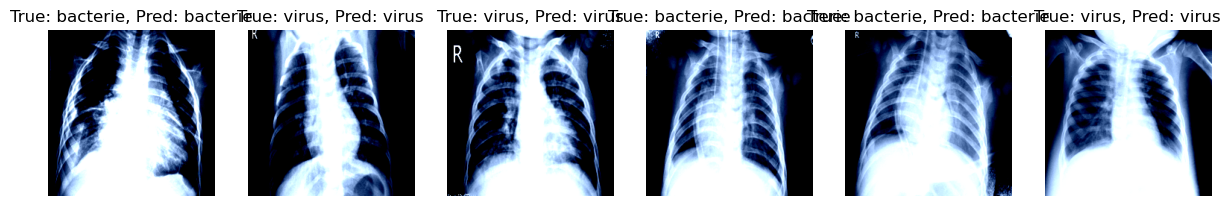

In [9]:
def visualize_predictions(dataset, model, num_images=6):
    model.eval()
    indices = np.random.choice(len(dataset), num_images, replace=False)
    fig, ax = plt.subplots(1, num_images, figsize=(15, 15))
    label_map = {0: 'normal', 1: 'bacterie', 2: 'virus'}
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            img, true_label = dataset[idx]
            img_input = img.unsqueeze(0).to(device)
            outputs = model(img_input)
            _, pred_label = torch.max(outputs, 1)
            ax[i].imshow(img.permute(1, 2, 0).cpu())
            ax[i].set_title(f"True: {label_map[true_label]}, Pred: {label_map[pred_label.item()]}")
            ax[i].axis('off')
    plt.show()

# Visualize predictions
visualize_predictions(test_dataset, model)